In [24]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid
import os
import numpy as np
import os
from pathlib import Path
import cv2
import PIL
from moviepy.editor import *

In [54]:
def visualize_maps_and_scene(map_dir='.', n_maps=10, num_to_skip=0,
                             get_from_back=False, make_movie=False):
    if map_dir is None:
        map_dirs = sorted(Path('maps').iterdir(), key=os.path.getmtime)
        map_dirs = [str(name) for name in map_dirs if '_' in str(name)]
        map_dir = map_dirs[-1]
    paths = sorted(Path(map_dir).iterdir(), key=os.path.getmtime)
    n_layers = 5
    map_names = [str(name) for name in paths if 'obstacle_map_159' in str(name)]
    ray_names = [str(name) for name in paths if 'obstacle_ray_map' in str(name)]
    rgb_names = [str(name) for name in paths if 'rgb' in str(name)]
    depth_names = [str(name) for name in paths if 'depth' in str(name)]

    if get_from_back:
        map_names = map_names[-(num_to_skip + n_maps):(-num_to_skip or None)]
        ray_names = ray_names[-(num_to_skip + n_maps):(-num_to_skip or None)]
        rgb_names = rgb_names[-(num_to_skip + n_maps):(-num_to_skip or None)]
        depth_names = depth_names[-(num_to_skip + n_maps):(-num_to_skip or None)]
    else:
        map_names = map_names[num_to_skip:num_to_skip + n_maps]
        ray_names = ray_names[num_to_skip:num_to_skip + n_maps]
        rgb_names = rgb_names[num_to_skip:num_to_skip + n_maps]
        depth_names = depth_names[num_to_skip:num_to_skip + n_maps]

    maps = []
    for i, name in enumerate(map_names):
        print(name)
        if 'npz' in name:
            obs_map = np.load(name)['arr_0']
        else:
            obs_map = np.loadtxt(name)
            
        map_scale = 80

        # plt.imshow(obs_map[200-map_scale:200+map_scale, 180-map_scale:200+map_scale])
        cont_map = obs_map[200-map_scale:200+map_scale, 180-map_scale:200+map_scale]
        
        cont_map = cv2.resize(cont_map, (480, 480))
        # maps.append(cont_map)
        thres_map = (obs_map[200-map_scale:200+map_scale, 180-map_scale:200+map_scale]
                     > 128).astype(float)
        
        kernel = np.ones((5,5),np.uint8)
        thres_map = cv2.morphologyEx(thres_map, cv2.MORPH_CLOSE, kernel)
        
        thres_map = cv2.resize(thres_map, (480, 480)).round().astype(int)
        maps.append(thres_map * 10)
        
        ray_name = ray_names[i]
        if 'npz' in ray_name:
            ray_map = np.load(ray_name)['arr_0']
        else:
            ray_map = np.loadtxt(ray_name)
        ray_map = ray_map[200-map_scale:200+map_scale, 180-map_scale:200+map_scale]
        ray_map = cv2.resize(ray_map, (480, 480)).astype(np.int64)
        ray_map += thres_map
        maps.append(ray_map)
        
        path_map_path = os.path.join(
            map_dir,
            'path_map_' + '_'.join(name.split('/')[-1].split('.')[0].split('_')[-2:]) + '.npz'
        )
        print(path_map_path)
        if os.path.exists(path_map_path):
            path_map = np.load(path_map_path)['arr_0']
        else:
            path_map = np.zeros((400, 400))
        path_map = path_map[200-map_scale:200+map_scale, 180-map_scale:200+map_scale]
        path_map = cv2.resize(path_map, (480, 480)).astype(np.int64)
        maps.append(path_map)
        
        
        if '.npy' in rgb_names[i]:
            maps.append(np.load(rgb_names[i]))
        else:
            maps.append(np.array(PIL.Image.open(rgb_names[i])))
        if '.npy' in depth_names[i]:
            maps.append(np.load(depth_names[i]).squeeze(2))
        else:
            maps.append(np.array(PIL.Image.open(depth_names[i])))
    
    prefix = 'maps/visualizations/'
    suffix = '_'.join(map_names[0].split('_')[-2:]).split('.')[0]    

    if make_movie:
        frames = np.zeros([len(map_names), 480 * 3, 480 + 640, 3])
        locations = [
            [0, 0],
            [480, 0],
            [960, 0],
            [0, 480],
            [480, 480]
        ]
        
        for i, image in enumerate(maps):
            location = locations[i % n_layers]
            frame_id = i // n_layers
            shape = image.shape
            
            if len(shape) == 2:
                image = (image / image.max() * 255).astype(int)
                frames[frame_id, location[0]:location[0] + shape[0],
                       location[1]:location[1] + shape[1],0] = image
            else:
                frames[frame_id, location[0]:location[0] + shape[0],
                       location[1]:location[1] + shape[1]] = image
        
        movie = ImageSequenceClip(list(frames), fps=2)
        movie = movie.resize(0.5)
        movie.write_videofile(prefix + suffix + '.mp4')
        
    else:
        fig = plt.figure(figsize=(6 * n_layers, 6 * len(map_names)))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(len(map_names), n_layers),  # creates 2x2 grid of axes
                         axes_pad=0.1,  # pad between axes in inch.
                         )

        for ax, im in zip(grid, maps):
            # Iterating over the grid returns the Axes.
            ax.imshow(im)

        fig.tight_layout()
        plt.savefig(prefix + suffix + '.png')
        plt.show()

In [ ]:
visualize_maps_and_scene(None, num_to_skip=0,
                         n_maps=200, get_from_back=True, make_movie=True)

maps/objectgoal_1591201535/obstacle_map_1591201536_0.npz
maps/objectgoal_1591201535/path_map_1591201536_0.npz
maps/objectgoal_1591201535/obstacle_map_1591201537_0.npz
maps/objectgoal_1591201535/path_map_1591201537_0.npz
maps/objectgoal_1591201535/obstacle_map_1591201538_0.npz
maps/objectgoal_1591201535/path_map_1591201538_0.npz
maps/objectgoal_1591201535/obstacle_map_1591201539_0.npz
maps/objectgoal_1591201535/path_map_1591201539_0.npz
maps/objectgoal_1591201535/obstacle_map_1591201540_0.npz
maps/objectgoal_1591201535/path_map_1591201540_0.npz
maps/objectgoal_1591201535/obstacle_map_1591201541_0.npz
maps/objectgoal_1591201535/path_map_1591201541_0.npz
maps/objectgoal_1591201535/obstacle_map_1591201542_0.npz
maps/objectgoal_1591201535/path_map_1591201542_0.npz
maps/objectgoal_1591201535/obstacle_map_1591201543_2412.npz
maps/objectgoal_1591201535/path_map_1591201543_2412.npz
maps/objectgoal_1591201535/obstacle_map_1591201544_4722.npz
maps/objectgoal_1591201535/path_map_1591201544_4722.np

t:   0%|          | 0/158 [00:00<?, ?it/s, now=None]

Moviepy - Building video maps/visualizations/1591201536_0.mp4.
Moviepy - Writing video maps/visualizations/1591201536_0.mp4



t:  51%|█████     | 80/158 [00:01<00:01, 53.96it/s, now=None]

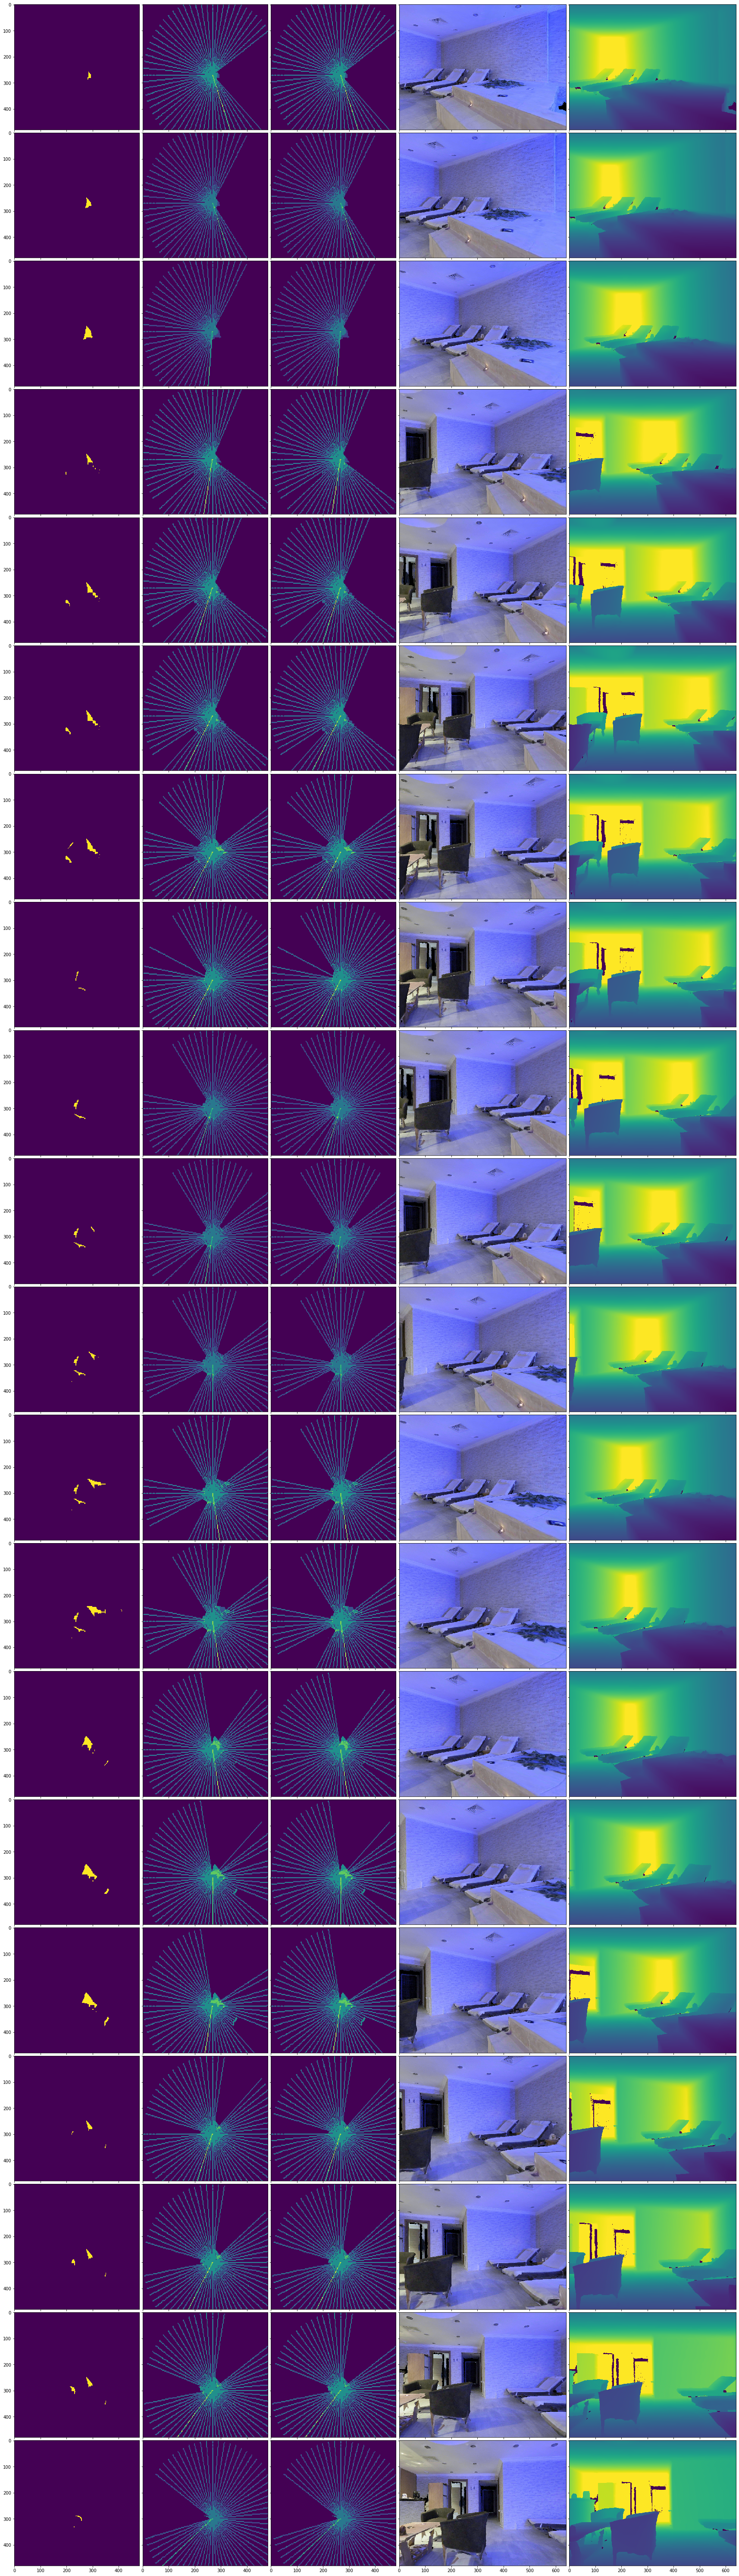

In [39]:
visualize_maps_and_scene('maps/objectgoal_1591092516', num_to_skip=0, n_maps=20, get_from_back=True)

In [ ]:
obs_map = np.loadtxt("obstacle_map_tensor(102959., device='cuda:0').csv")
obs_map.shape, obs_map.sum()

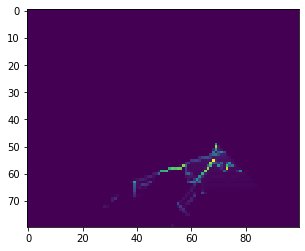

In [25]:
map_scale = 40
plt.imshow(obs_map[200-map_scale:200+map_scale, 180-map_scale:200+map_scale])